In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 
mushroom = pl.DataFrame(pd.concat([X, y], axis=1)).rename({"poisonous": "class"})

In [3]:
train = pl.read_csv("train.csv").drop("id")
train.describe()

statistic,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
str,str,f64,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str
"""count""","""3116945""",3.116941e6,"""3116905""","""2445922""","""3116933""","""3116937""","""2593009""","""1858510""","""3116888""",3.116945e6,3.116945e6,"""359922""","""1136084""","""3116907""","""159452""","""375998""","""3116921""","""2988065""","""267263""","""3116900""","""3116945"""
"""null_count""","""0""",4.0,"""40""","""671023""","""12""","""8""","""523936""","""1258435""","""57""",0.0,0.0,"""2757023""","""1980861""","""38""","""2957493""","""2740947""","""24""","""128880""","""2849682""","""45""","""0"""
"""mean""",null,6.309848,null,null,null,null,null,null,null,6.348333,11.153785,null,null,null,null,null,null,null,null,null,null
"""std""",null,4.657931,null,null,null,null,null,null,null,2.699755,8.095477,null,null,null,null,null,null,null,null,null,null
"""min""","""e""",0.03,"""0""","""0""","""1""","""2""","""0""","""0""","""0""",0.0,0.0,"""1""","""0""","""1""","""21""","""2""","""10""","""1""","""10 None""","""1""","""a"""
"""25%""",null,3.32,null,null,null,null,null,null,null,4.67,4.97,null,null,null,null,null,null,null,null,null,null
"""50%""",null,5.75,null,null,null,null,null,null,null,5.88,9.65,null,null,null,null,null,null,null,null,null,null
"""75%""",null,8.24,null,null,null,null,null,null,null,7.41,15.63,null,null,null,null,null,null,null,null,null,null
"""max""","""p""",80.67,"""z""","""z""","""z""","""z""","""z""","""y""","""z""",88.72,102.9,"""z""","""z""","""z""","""y""","""z""","""z""","""z""","""y""","""z""","""w"""


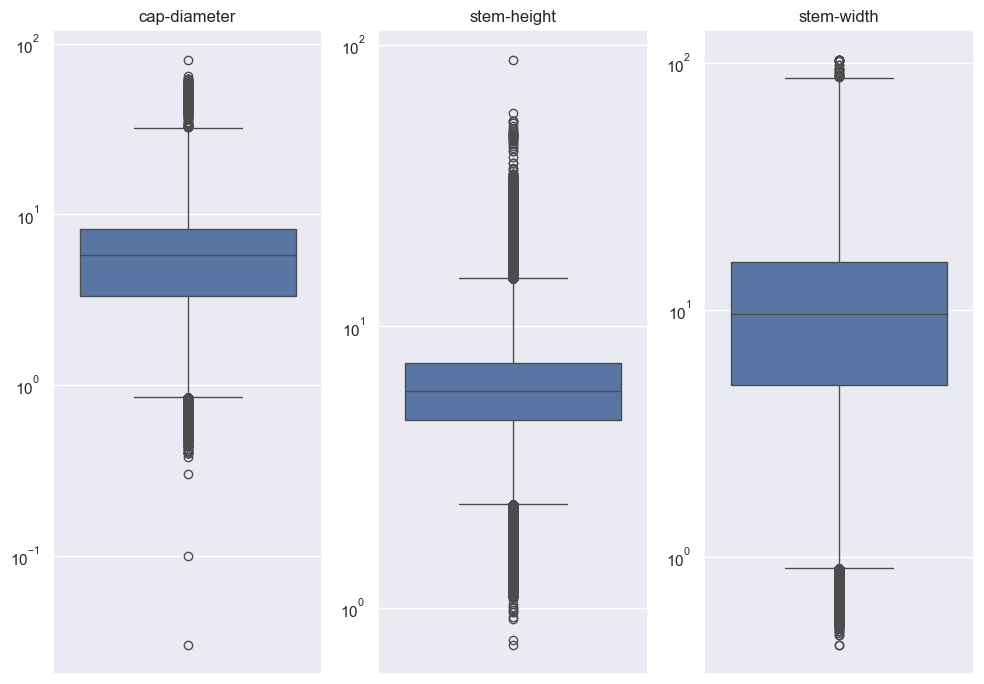

In [4]:
sns.set_theme(rc={'figure.figsize':(10,7)})

# Assuming 'train' is a DataFrame or similar structure
numeric_column_df = train.select(pl.col(pl.Float64), pl.col(pl.Int64))
n_rows = 1
n_cols = 3

# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

# Flatten axes in case of multiple rows or columns, though here it's just 1 row
axes = axes.flatten()

for i, column in enumerate(numeric_column_df.columns):
    sns.boxplot(numeric_column_df[column], ax=axes[i % n_cols], log_scale=True).set_title(column)

plt.tight_layout()
plt.show()


Looking at a boxplot of the numeric values, it seems that there are a few outliers. For the beginning we will ignore, we might try some outlier detection later on to see wheter dealing with them improves performance.
Next up, we'll clean the data and (using the original data) only keep the values that are present in the original data for each feature.

In [5]:
train = train.with_columns([
    pl.when(
        pl.col("cap-shape").is_in(["b", "c", "x", "f", "k", "s"])
    ).then(
        pl.col("cap-shape")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("cap-surface").is_in(["f", "g", "y", "s"])
    ).then(
        pl.col("cap-surface")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("cap-color").is_in(["n", "b", "c", "g", "r", "p", "u", "e", "w", "y"])
    ).then(
        pl.col("cap-color")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("does-bruise-or-bleed").is_in(["t", "f"])
    ).then(
        pl.col("does-bruise-or-bleed")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("gill-attachment").is_in(["a", "d", "f", "n"])
    ).then(
        pl.col("gill-attachment")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("gill-spacing").is_in(["c", "w", "d"])
    ).then(
        pl.col("gill-spacing")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("gill-color").is_in(["k", "n", "b", "h", "g", "r", "o", "p", "u", "e", "w", "y"])
    ).then(
        pl.col("gill-color")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("veil-type").is_in(["p", "u"])
    ).then(
        pl.col("veil-type")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("veil-color").is_in(["n", "o", "w", "y"])
    ).then(
        pl.col("veil-color")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("has-ring").is_in(["t", "f"])
    ).then(
        pl.col("has-ring")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("ring-type").is_in(["c", "e", "f", "l", "n", "p", "s", "z"])
    ).then(
        pl.col("ring-type")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("spore-print-color").is_in(["k", "n", "b", "h", "r", "o", "u", "w", "y"])
    ).then(
        pl.col("spore-print-color")
    ).otherwise(
        pl.lit(None)
    ),
    pl.when(
        pl.col("habitat").is_in(["g", "l", "m", "p", "u", "w", "d"])
    ).then(
        pl.col("habitat")
    ).otherwise(
        pl.lit(None)
    ),
    # all other categorical variables follow the same structure / are only 1 letter
    pl.col("stem-root").map_elements(lambda x: x[0] if len(x) == 1 and x[0].islower() else None, return_dtype=pl.String),
    pl.col("stem-surface").map_elements(lambda x: x[0] if len(x) == 1 and x[0].islower() else None, return_dtype=pl.String),
    pl.col("stem-color").map_elements(lambda x: x[0] if len(x) == 1 and x[0].islower() else None, return_dtype=pl.String)
])

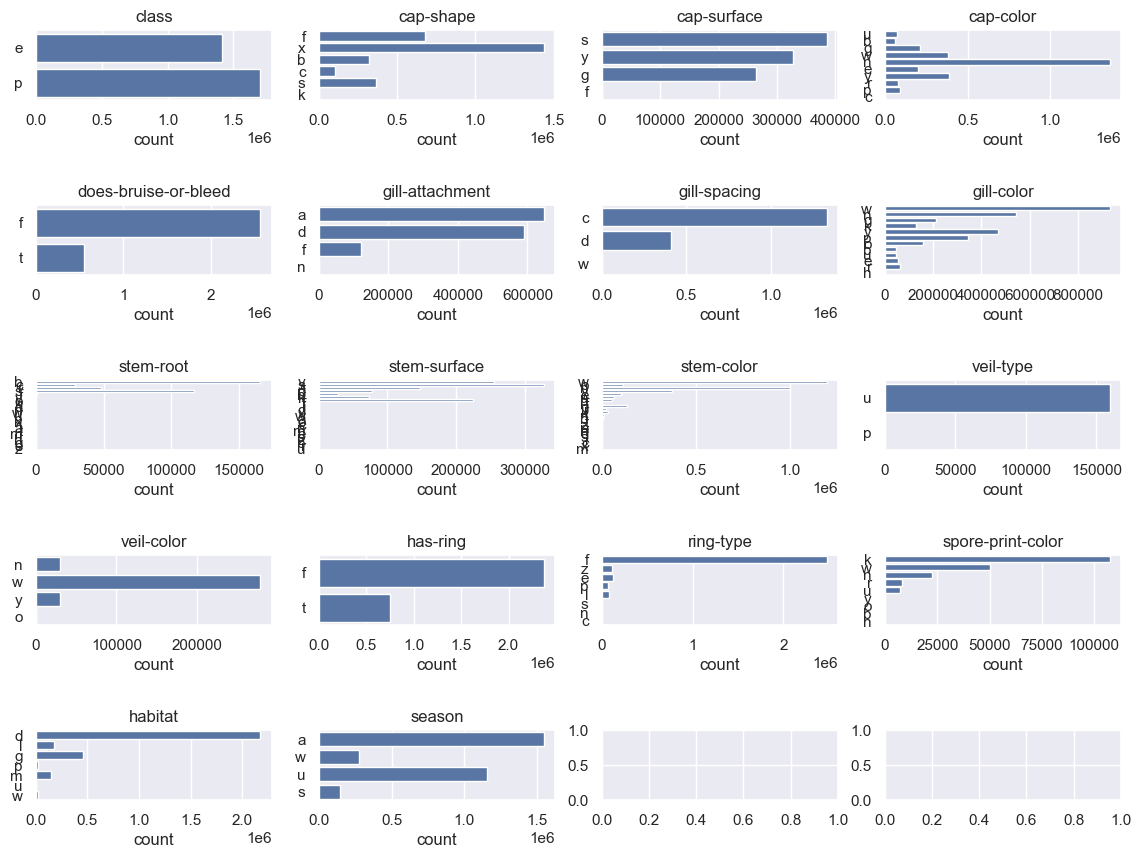

In [6]:
sns.set_theme(rc={'figure.figsize':(14,10)})
string_columns = train.select(pl.col(pl.String))
n_rows=5
n_cols=4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
for i, column in enumerate(string_columns.columns):
    sns.countplot(string_columns[column], ax=axes[i // n_cols, i % n_cols]).set_title(column)

plt.subplots_adjust(hspace=1.5)

Looks like there are a bunch of features that have values that don't really occur that often. It might make sense to throw all of them into a 'other' category in order to speed up computation.

In [7]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

In [6]:
limit = 20000
train=train.with_columns([
    pl.when(
        pl.col("gill-color").is_in([key for key, value in Counter(train["gill-color"]).items() if value < 20000])
    ).then(
        pl.lit("Other")
    ).otherwise(
        pl.col("gill-color")
    ).alias("gill-color"),
    pl.when(
        pl.col("stem-root").is_in([key for key, value in Counter(train["stem-root"]).items() if value < 20000])
    ).then(
        pl.lit("Other")
    ).otherwise(
        pl.col("stem-root")
    ).alias("stem-root"),
    pl.when(
        pl.col("stem-surface").is_in([key for key, value in Counter(train["stem-surface"]).items() if value < 20000])
    ).then(
        pl.lit("Other")
    ).otherwise(
        pl.col("stem-surface")
    ).alias("stem-surface"),
    pl.when(
        pl.col("stem-color").is_in([key for key, value in Counter(train["stem-color"]).items() if value < 20000])
    ).then(
        pl.lit("Other")
    ).otherwise(
        pl.col("stem-color")
    ).alias("stem-color"),
    pl.when(
        pl.col("ring-type").is_in([key for key, value in Counter(train["ring-type"]).items() if value < 20000])
    ).then(
        pl.lit("Other")
    ).otherwise(
        pl.col("ring-type")
    ).alias("ring-type"),
    pl.when(
        pl.col("spore-print-color").is_in([key for key, value in Counter(train["spore-print-color"]).items() if value < 20000])
    ).then(
        pl.lit("Other")
    ).otherwise(
        pl.col("spore-print-color")
    ).alias("spore-print-color")
])

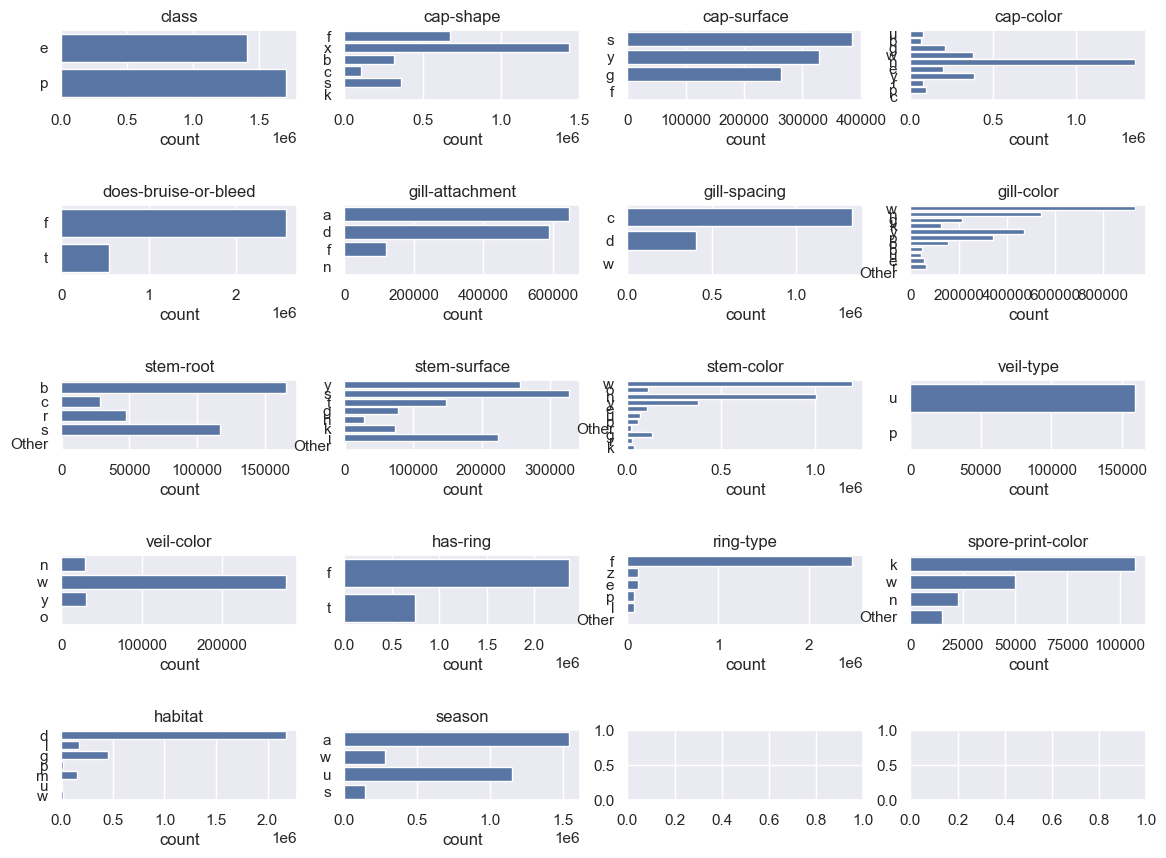

In [31]:
sns.set_theme(rc={'figure.figsize':(14,10)})
string_columns = train.select(pl.col(pl.String))
n_rows=5
n_cols=4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
for i, column in enumerate(string_columns.columns):
    sns.countplot(string_columns[column], ax=axes[i // n_cols, i % n_cols]).set_title(column)

plt.subplots_adjust(hspace=1.5)

In [8]:
X=train.drop("class")
y=train["class"]
X=pl.concat([X.select(pl.col(pl.String)).to_dummies(), X.select(pl.col(pl.Float64))], how="horizontal")

In [40]:
from sklearn.preprocessing import LabelEncoder

test_size = 0.2
random_state = 2345
X_train, X_val, y_train, y_val = train_test_split(X.to_pandas(), y.to_pandas(), test_size=test_size, random_state=random_state)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)

In [29]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tqdm import tqdm

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [41]:
base_models=[
    HistGradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    CatBoostClassifier(random_state=random_state, silent=True),
    LGBMClassifier(random_state=random_state, verbose=0),
    XGBClassifier(random_state=random_state)
]
trained_base_models = [model.fit(X_train, y_train) for model in tqdm(base_models)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [20:29<00:00, 245.95s/it]


In [42]:
from sklearn.metrics import f1_score
predicted_classes = [model.predict(X_val) for model in trained_base_models]
f1_validation = [f1_score(y_val, classes) for classes in predicted_classes]

In [45]:
print(f"""
F1 for HistGradientBoostingClassifier: {f1_validation[0]:.4}
F1 for RandomForestClassifier: {f1_validation[1]:.4}
F1 for CatBoostClassifier: {f1_validation[2]:.4}
F1 for LGBMClassifier: {f1_validation[3]:.4}
F1 for XGBClassifier: {f1_validation[4]:.4}
""")


F1 for HistGradientBoostingClassifier: 0.9883
F1 for RandomForestClassifier: 0.9923
F1 for CatBoostClassifier: 0.9918
F1 for LGBMClassifier: 0.988
F1 for XGBClassifier: 0.9909



In [46]:
from optuna_integration.xgboost import XGBoostPruningCallback
# first we'll define the objective functions that we will use for tuning
def objective_hist_gradient_boosting(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_iter': trial.suggest_int('max_iter', 50, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 0, 1.0),
        'max_features': trial.suggest_float('max_features', 0, 1),
        'max_bins': trial.suggest_int('max_bins', 2, 255),
        'random_state': random_state
    }
    mod = HistGradientBoostingClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv = abs(cross_val_score(mod, X_train, y_train, cv=skf, scoring='f1').mean())
    return cv

def objective_random_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': random_state
    }
    mod = RandomForestClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv = abs(cross_val_score(mod, X_train, y_train, cv=skf, scoring='f1').mean())
    return cv

def objective_cat_boost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),
        'grow_policy': 'Lossguide',
        'random_state': random_state,
        'silent': True
    }
    mod = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv = abs(cross_val_score(mod, X_train, y_train, cv=skf, scoring='f1').mean())
    return cv
    
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1),
        'metric': 'f1',
        'random_state': random_state,
        'verbose': 0
    }
    mod = LGBMClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv = abs(cross_val_score(mod, X_train, y_train, cv=skf, scoring='f1').mean())
    return cv

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'f1',
        'use_label_encoder': False,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'random_state': random_state,
    }
    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        params['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        params['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        params['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    mod = XGBClassifier(
        **params, 
        early_stopping_rounds=100,
        callbacks=[XGBoostPruningCallback(trial=trial, observation_key="validation_0-f1")],
        verbosity=0
        )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train.reset_index(), y_train):
        X_train_cv = X_train.iloc[train_idx]
        X_val_cv = X_train.iloc[val_idx]
        y_train_cv = y_train[train_idx]
        y_val_cv = y_train[val_idx]
        
        mod.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            verbose=False
        )
        # Report intermediate objective value
        val_pred = mod.predict_proba(X_val_cv)
        logloss = log_loss(y_val_cv, val_pred)
        trial.report(logloss, step=len(cv_scores))
        
        # Prune if the trial is unpromising
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        cv_scores.append(logloss)
    return np.mean(cv_scores)

In [ ]:
import optuna
import json
from sklearn.model_selection import cross_val_score, StratifiedKFold
hist_gradient_boosting_study = optuna.create_study(direction="minimize", study_name="s_1")
random_forest_study = optuna.create_study(direction="minimize", study_name="s_2")
cat_boost_study = optuna.create_study(direction="minimize", study_name="s_3")
lgbm_study = optuna.create_study(direction="minimize", study_name="s_4")
xgb_study = optuna.create_study(direction="minimize", study_name="s_5")
n_trials=20
n_jobs=1
hist_gradient_boosting_study.optimize(objective_hist_gradient_boosting, n_trials=n_trials, n_jobs=n_jobs)
with open("params_hist_gradient_boosting.json", "w") as f:
    json.dump(hist_gradient_boosting_study.best_params, f)
random_forest_study.optimize(objective_random_forest, n_trials=n_trials, n_jobs=n_jobs)
with open("params_random_forest.json", "w") as f:
    json.dump(random_forest_study.best_params, f)
cat_boost_study.optimize(objective_cat_boost, n_trials=n_trials, n_jobs=n_jobs)
with open("params_cat_boost.json", "w") as f:
    json.dump(cat_boost_study.best_params, f)
lgbm_study.optimize(objective_lgbm, n_trials=n_trials, n_jobs=n_jobs)
with open("params_lgbm.json", "w") as f:
    json.dump(lgbm_study.best_params, f)
xgb_study.optimize(objective_xgb, n_trials=n_trials, n_jobs=n_jobs)
with open("params_xgb.json", "w") as f:
    json.dump(xgb_study.best_params, f)

[I 2024-08-19 11:32:28,287] A new study created in memory with name: s_1
[I 2024-08-19 11:32:28,288] A new study created in memory with name: s_2
[I 2024-08-19 11:32:28,288] A new study created in memory with name: s_3
[I 2024-08-19 11:32:28,289] A new study created in memory with name: s_4
[I 2024-08-19 11:32:28,290] A new study created in memory with name: s_5
[I 2024-08-19 11:44:41,346] Trial 0 finished with value: 0.9918395884573202 and parameters: {'learning_rate': 0.1595038846337365, 'max_iter': 240, 'max_leaf_nodes': 66, 'max_depth': 24, 'min_samples_leaf': 58, 'l2_regularization': 0.15567387786012366, 'max_features': 0.9689735852363185, 'max_bins': 222}. Best is trial 0 with value: 0.9918395884573202.


In [9]:
from catboost import CatBoostClassifier
mod = CatBoostClassifier()
mod.fit(X_train, y_train)

998:	learn: 0.0394319	total: 6m 3s	remaining: 364ms
999:	learn: 0.0394319	total: 6m 4s	remaining: 0us


In [14]:
importances = mod.get_feature_importance()
importances = pd.Series(importances, index=X.columns).sort_values()

In [25]:
X = X[list(importances[importances >= 1].index)]
X_train, X_val, y_train, y_val = train_test_split(X.to_pandas(), y.to_pandas(), test_size=test_size, random_state=random_state)

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_val, y_train, y_val)

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 18/31 [57:41<21:38, 99.86s/it]